In [1]:
import torch
import torch.nn as nn
import numpy as np
import random
from scipy.fftpack import dct, idct
from PIL import Image
import torch.nn.functional as F

In [16]:

class FreqMix(nn.Module):
    def __init__(self, ratios=[0.0, 1.0], patch=-1, random_seed=None):
        super().__init__()
        if not (0.0 <= ratios[0] <= 1.0 and 0.0 <= ratios[1] <= 1.0):
            raise ValueError("Ratios must be between 0.0 and 1.0")
        if ratios[0] > ratios[1]:
            raise ValueError("ratios[0] must be <= ratios[1]")
        if patch != -1 and patch <= 0:
            raise ValueError("patch must be positive or -1")

        self.ratios = ratios
        self.patch = patch
        self.random_seed = random_seed

    def apply_2d_dct(self, patch):
        return dct(dct(patch.T, norm="ortho").T, norm="ortho")

    def apply_2d_idct(self, patch):
        return idct(idct(patch.T, norm="ortho").T, norm="ortho")

    def process_patches(self, real_channel, fake_channel, blend_ratio):
        height, width = real_channel.shape
        mixed_channel = np.zeros_like(real_channel, dtype=np.float32)
        
        step_size = self.patch // 2 if self.patch >= 16 else self.patch
        normalization_map = np.zeros_like(real_channel, dtype=np.float32)

        for i in range(0, height, step_size):
            for j in range(0, width, step_size):
                end_i = min(i + self.patch, height)
                end_j = min(j + self.patch, width)

                real_p = real_channel[i:end_i, j:end_j].astype(np.float32)
                fake_p = fake_channel[i:end_i, j:end_j].astype(np.float32)

                curr_h, curr_w = real_p.shape
                
                if (curr_h, curr_w) != (self.patch, self.patch):
                    pad_h = self.patch - curr_h
                    pad_w = self.patch - curr_w
                    real_p = np.pad(real_p, ((0, pad_h), (0, pad_w)), mode="edge")
                    fake_p = np.pad(fake_p, ((0, pad_h), (0, pad_w)), mode="edge")

                real_dct = self.apply_2d_dct(real_p)
                fake_dct = self.apply_2d_dct(fake_p)
                
                mixed_dct = blend_ratio * real_dct + (1 - blend_ratio) * fake_dct
                mixed_p = self.apply_2d_idct(mixed_dct)

                mixed_p = mixed_p[:curr_h, :curr_w]
                
                mixed_channel[i:end_i, j:end_j] += mixed_p
                normalization_map[i:end_i, j:end_j] += 1.0

        normalization_map[normalization_map == 0] = 1.0
        mixed_channel = mixed_channel / normalization_map
        
        return np.round(np.clip(mixed_channel, 0, 255)).astype(np.uint8)
    @torch.no_grad()
    def forward(self, real_img, fake_img):
        if self.random_seed is not None:
            random.seed(self.random_seed)
            np.random.seed(self.random_seed)

        is_tensor_input = False
        if isinstance(real_img, torch.Tensor):
            is_tensor_input = True
            if real_img.dim() == 4:
                real_img = real_img.squeeze(0)
            real_img = real_img.cpu().permute(1, 2, 0).numpy()
            real_img = (real_img * 255).astype(np.uint8)
            real_img = Image.fromarray(real_img)
            
        if isinstance(fake_img, torch.Tensor):
            if fake_img.dim() == 4:
                fake_img = fake_img.squeeze(0)
            fake_img = fake_img.cpu().permute(1, 2, 0).numpy()
            fake_img = (fake_img * 255).astype(np.uint8)
            fake_img = Image.fromarray(fake_img)

        if real_img.size != fake_img.size:
            fake_img = fake_img.resize(real_img.size, Image.LANCZOS)

        if real_img.mode != "RGB":
            real_img = real_img.convert("RGB")
        if fake_img.mode != "RGB":
            fake_img = fake_img.convert("RGB")

        real_np = np.array(real_img)
        fake_np = np.array(fake_img)
        
        height, width, _ = real_np.shape
        
        current_patch = self.patch
        if current_patch != -1 and current_patch > min(height, width):
            current_patch = -1

        ratio = random.uniform(self.ratios[0], self.ratios[1])
        print(ratio)
        mixed_channels = []

        for c in range(3):
            real_c = real_np[:, :, c]
            fake_c = fake_np[:, :, c]

            if current_patch == -1:
                real_c_f = real_c.astype(np.float32)
                fake_c_f = fake_c.astype(np.float32)
                
                real_dct = self.apply_2d_dct(real_c_f)
                fake_dct = self.apply_2d_dct(fake_c_f)
                
                mixed_dct = ratio * real_dct + (1 - ratio) * fake_dct
                mixed_c = self.apply_2d_idct(mixed_dct)
                mixed_c = np.round(np.clip(mixed_c, 0, 255)).astype(np.uint8)
                mixed_channels.append(mixed_c)
            else:
                mixed_c = self.process_patches(real_c, fake_c, ratio)
                mixed_channels.append(mixed_c)

        mixed_np = np.stack(mixed_channels, axis=2)
        output_img = Image.fromarray(mixed_np)

        if is_tensor_input:
            tensor_out = torch.from_numpy(np.array(output_img)).float() / 255.0
            return tensor_out.permute(2, 0, 1)
            
        return output_img

    def __repr__(self):
        return f"{self.__class__.__name__}(ratios={self.ratios}, patch={self.patch})"

In [17]:
def mse(a,b):
    return ((a - b)**2).mean()

In [18]:
from PIL import Image
import torchvision.transforms.functional as tvf
real_pil = Image.open("../src/real.png")
recon_pil = Image.open("../src/recon.png")
real = tvf.to_tensor(real_pil)
recon = tvf.to_tensor(recon_pil)


In [25]:
mixer =  FreqMix(ratios = [0,0.8])
result = mixer(real,recon).squeeze()
result_pil = tvf.to_pil_image(result)
mse(recon, result),mse(real, result)


0.7998959773760402


(tensor(6.4124e-05), tensor(3.8967e-06))

In [20]:
def plot_comparisons(real, recon, mixed):
    """
    Plots two rows:
    1. Real vs Recon (and Residual)
    2. Real vs Mixed (and Residual)
    """
    real_np = np.array(real).astype(np.float32)
    recon_np = np.array(recon).astype(np.float32)
    mixed_np = np.array(mixed).astype(np.float32)

    # Calculate Residuals (Mean across RGB channels)
    resid_recon = np.mean(np.abs(real_np - recon_np), axis=2)
    resid_mixed = np.mean(np.abs(real_np - mixed_np), axis=2)

    # Common scale for heatmap comparison
    # We use 99th percentile of the recon error as the max scale for both
    vmax = np.percentile(resid_recon, 99)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # --- ROW 1: Recon vs Real ---
    axes[0, 0].imshow(real)
    axes[0, 0].set_title("Original (Real)")
    axes[0, 0].axis("off")

    axes[0, 1].imshow(recon)
    axes[0, 1].set_title("VAE Reconstruction")
    axes[0, 1].axis("off")

    im1 = axes[0, 2].imshow(resid_recon, cmap='inferno', vmin=0, vmax=vmax)
    axes[0, 2].set_title(f"Residual: |Real - Recon|\n(Mean Err: {np.mean(resid_recon):.2f})")
    axes[0, 2].axis("off")
    fig.colorbar(im1, ax=axes[0, 2], fraction=0.046, pad=0.04)

    # --- ROW 2: Mixed vs Real ---
    axes[1, 0].imshow(real)
    axes[1, 0].set_title("Original (Real)")
    axes[1, 0].axis("off")

    axes[1, 1].imshow(mixed)
    axes[1, 1].set_title("Frequency Mixed ")
    axes[1, 1].axis("off")

    im2 = axes[1, 2].imshow(resid_mixed, cmap='inferno', vmin=0, vmax=vmax)
    axes[1, 2].set_title(f"Residual: |Real - Mixed|\n(Mean Err: {np.mean(resid_mixed):.2f})")
    axes[1, 2].axis("off")
    fig.colorbar(im2, ax=axes[1, 2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

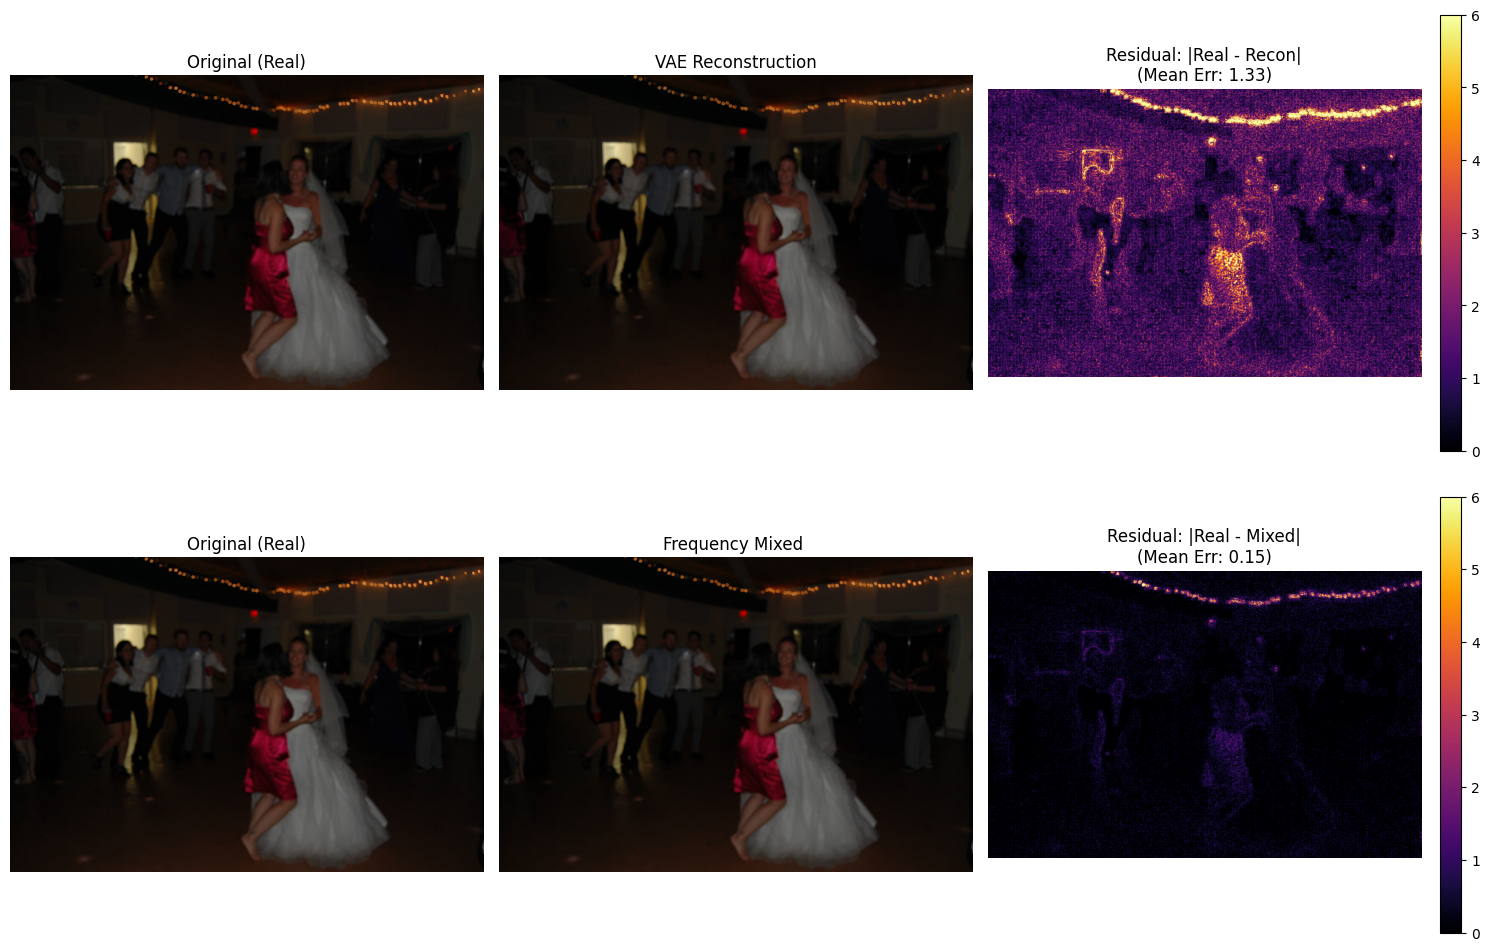

In [27]:
import matplotlib.pyplot as plt
plot_comparisons(real_pil,recon_pil,result_pil)

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.fftpack import fft2, fftshift

def calc_and_plot_freq_error(real_img, fake_img, save_plot_path=None):
    """
    Calculates relative frequency error (Low vs High band) between a Real and Fake image
    and plots a Bar Chart.

    """

    # 1. Load Images
    try:
        real_img = real_img.convert("L") # Convert to Grayscale for DFT
        size = real_img.size
        fake_img = fake_img.convert("L")
    except FileNotFoundError as e:
        print(f"Error loading images: {e}")
        return

    # Resize fake to match real if necessary
    if real_img.size != fake_img.size:
        fake_img = fake_img.resize(real_img.size, Image.LANCZOS)

    # 2. Prepare Data (Numpy)
    real_np = np.array(real_img).astype(np.float32)
    fake_np = np.array(fake_img).astype(np.float32)

    rows, cols = real_np.shape
    crow, ccol = rows // 2, cols // 2

    # 3. Compute DFT (Discrete Fourier Transform)
    # fft2: 2D FFT, fftshift: Center low frequencies
    fft_real = fftshift(fft2(real_np))
    fft_fake = fftshift(fft2(fake_np))

    # Calculate Magnitude Spectrum
    mag_real = np.abs(fft_real)
    mag_fake = np.abs(fft_fake)

    # Calculate Magnitude Difference (Absolute Error)
    diff_mag = np.abs(mag_real - mag_fake)

    # 4. Define Bands (Low vs High)
    # We define "Low Frequency" as the inner 15% radius of the spectrum
    radius = min(rows, cols) * 0.15
    y, x = np.ogrid[-crow:rows-crow, -ccol:cols-ccol]
    mask = x*x + y*y <= radius*radius  # True for Low Freq, False for High Freq

    # 5. Calculate Relative Errors
    # Error = Sum(Difference) / Sum(Base Magnitude)
    # Added 1e-8 to avoid division by zero

    low_freq_err = np.sum(diff_mag * mask) / (np.sum(mag_real * mask) + 1e-8)
    high_freq_err = np.sum(diff_mag * (~mask)) / (np.sum(mag_real * (~mask)) + 1e-8)

    print(f"--- Frequency Error Analysis ---")
    print(f"Low Frequency Error:  {low_freq_err:.4f}")
    print(f"High Frequency Error: {high_freq_err:.4f}")

    # 6. Plot Bar Chart
    labels = ['Low Frequency\n(Structure)', 'High Frequency\n(Edges/Noise)']
    values = [low_freq_err, high_freq_err]
    colors = ['#4CAF50', '#FF5722'] # Green for Low, Orange for High

    plt.figure(figsize=(8, 6))
    bars = plt.bar(labels, values, color=colors, width=0.5, edgecolor='black', alpha=0.8)

    plt.ylabel('Relative Error Magnitude (Normalized)')
    plt.title(f'Frequency Domain Error Analysis\nReal vs fake ')
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.4f}',
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.tight_layout()

    if save_plot_path:
        plt.savefig(save_plot_path)
        print(f"Bar chart saved to {save_plot_path}")

    plt.show()


--- Frequency Error Analysis ---
Low Frequency Error:  0.0639
High Frequency Error: 0.4417


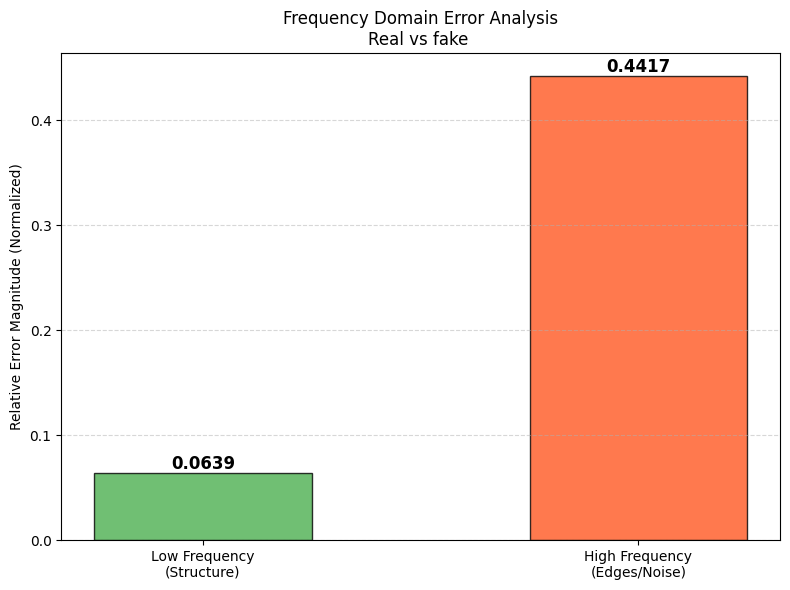

In [23]:
calc_and_plot_freq_error(real_pil,recon_pil)

--- Frequency Error Analysis ---
Low Frequency Error:  0.0127
High Frequency Error: 0.1209


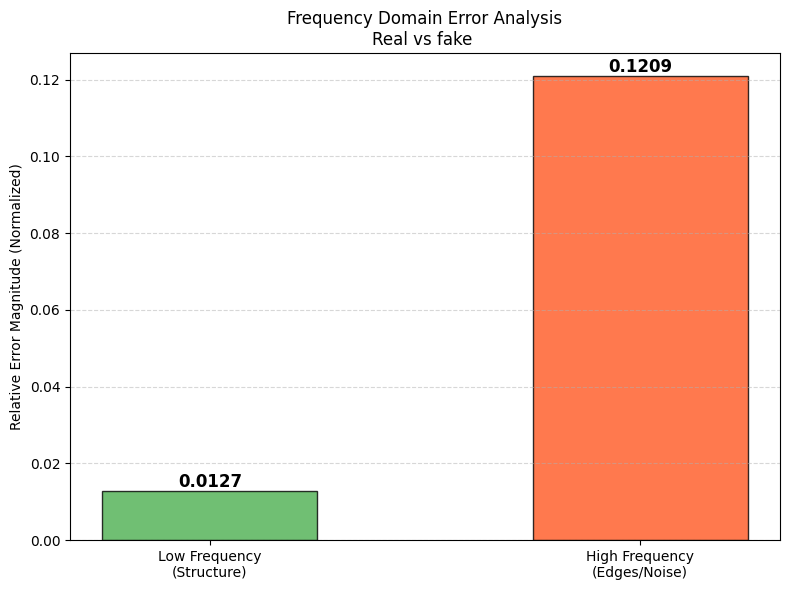

In [26]:
calc_and_plot_freq_error(real_pil,result_pil)